In [1]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
# 超参数设置
config = {
    "model_name": "resnet",  # 可选 "resnet" 或 "vgg"
    "num_epochs": 15,
    "batch_size": 32,
    "learning_rate": 0.001,
    "test_size": 0.2,
    "sample_ratio": 1.0
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "Aerial_Landscapes/"


In [3]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    input_size = 224
    if model_name == "resnet":
        model = models.resnet18(pretrained=use_pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "vgg":
        model = models.vgg16(pretrained=use_pretrained)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    else:
        raise ValueError("不支持的模型名称，请选择 'resnet' 或 'vgg'")
    return model, input_size


In [4]:
def get_transforms(input_size=224):
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform


In [5]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label


In [6]:
def load_and_split_dataset(root_dir, test_size=0.2, sample_ratio=1.0):
    classes = sorted(os.listdir(root_dir))
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    train_images, train_labels = [], []
    test_images, test_labels = [], []

    for cls_name in classes:
        cls_path = os.path.join(root_dir, cls_name)
        img_files = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.endswith('.jpg')]
        random.seed(42)
        random.shuffle(img_files)
        n_samples = int(len(img_files) * sample_ratio)
        split = int(n_samples * (1 - test_size))
        imgs = img_files[:n_samples]
        train_imgs = imgs[:split]
        test_imgs = imgs[split:]
        train_images.extend([cv2.imread(p) for p in train_imgs])
        train_labels.extend([class_to_idx[cls_name]] * len(train_imgs))
        test_images.extend([cv2.imread(p) for p in test_imgs])
        test_labels.extend([class_to_idx[cls_name]] * len(test_imgs))

    return (train_images, train_labels), (test_images, test_labels), classes


In [7]:

def train_model(model, device, train_loader, test_loader, criterion, optimizer,
                num_epochs=25, checkpoint_path='checkpoint.pth', patience=5):
    """
    模型训练函数，加入 Early Stopping 和历史记录
    """
    best_acc = 0.0
    epochs_no_improve = 0
    early_stop = False
    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }

    for epoch in range(num_epochs):
        if early_stop:
            print(f"⚠️ 早停触发于第 {epoch+1} 轮")
            break

        # 训练阶段
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data)
            total_train += labels.size(0)

        epoch_train_loss = train_loss / total_train
        epoch_train_acc = correct_train.double() / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())

        # 验证阶段
        model.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == labels.data)
                total_test += labels.size(0)

        epoch_test_loss = test_loss / total_test
        epoch_test_acc = correct_test.double() / total_test
        history['test_loss'].append(epoch_test_loss)
        history['test_acc'].append(epoch_test_acc.item())

        print(f"Epoch {epoch+1}: Train Acc={epoch_train_acc:.4f}, Test Acc={epoch_test_acc:.4f}")

        # Early Stopping 判断
        if epoch_test_acc > best_acc:
            best_acc = epoch_test_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), checkpoint_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop = True

    return model, history


In [8]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels)
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation='vertical', cmap='Blues')


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.6705, Test Acc=0.7696
Epoch 2: Train Acc=0.7664, Test Acc=0.8229
Epoch 3: Train Acc=0.7971, Test Acc=0.8563
Epoch 4: Train Acc=0.8231, Test Acc=0.8813
Epoch 5: Train Acc=0.8345, Test Acc=0.8604
Epoch 6: Train Acc=0.8408, Test Acc=0.8875
Epoch 7: Train Acc=0.8481, Test Acc=0.8783
Epoch 8: Train Acc=0.8633, Test Acc=0.9058
Epoch 9: Train Acc=0.8722, Test Acc=0.9029
Epoch 10: Train Acc=0.8714, Test Acc=0.9025
Epoch 11: Train Acc=0.8681, Test Acc=0.8925
Epoch 12: Train Acc=0.8760, Test Acc=0.8925
Epoch 13: Train Acc=0.8793, Test Acc=0.9125
Epoch 14: Train Acc=0.8804, Test Acc=0.9263
Epoch 15: Train Acc=0.8900, Test Acc=0.9163
Evaluation Metrics (Precision, Recall, F1-score):

              precision    recall  f1-score   support

 Agriculture     0.8908    0.9688    0.9281       160
     Airport     0.8812    0.8812    0.8812       160
       Beach     0.9933    0.9313    0.9613       160
        City     0.9012    0.9125    0.9068       160
      Desert     0.8674    

<Figure size 1200x1000 with 0 Axes>

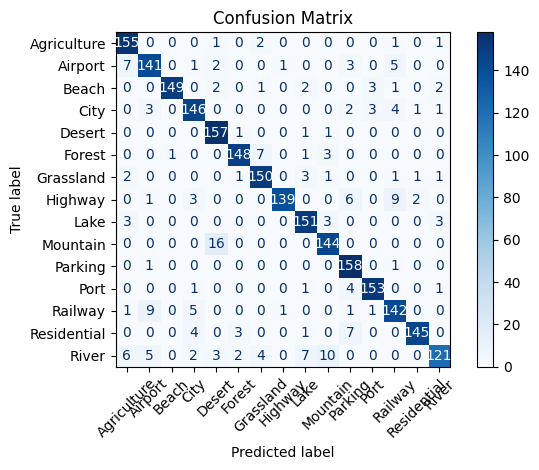

In [9]:
# 加载数据
(train_images, train_labels), (test_images, test_labels), classes = load_and_split_dataset(
    dataset_path,
    test_size=config["test_size"],
    sample_ratio=config["sample_ratio"]
)

# 初始化模型
model, input_size = initialize_model(
    model_name=config["model_name"],
    num_classes=len(classes),
    use_pretrained=True
)
model = model.to(device)

# 数据增强
train_transform, test_transform = get_transforms(input_size)

# 构建Dataset和Loader
train_dataset = CustomDataset(train_images, train_labels, train_transform)
test_dataset = CustomDataset(test_images, test_labels, test_transform)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

# 损失函数与优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# 训练模型
model, history = train_model(
    model, device, train_loader, test_loader,
    criterion, optimizer,
    num_epochs=config["num_epochs"],
    patience=5
)

# 评估
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels)
        y_pred.extend(preds.cpu().numpy())

# 输出三种指标：precision、recall、f1-score
report = classification_report(y_true, y_pred, target_names=classes, digits=4)
print("Evaluation Metrics (Precision, Recall, F1-score):\n")
print(report)

# 混淆矩阵可视化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(12, 10))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


In [10]:
def run_and_evaluate(model_name, classes):
    # 加载数据
    (train_images, train_labels), (test_images, test_labels), _ = load_and_split_dataset(
        dataset_path,
        test_size=config["test_size"],
        sample_ratio=config["sample_ratio"]
    )

    # 初始化模型
    model, input_size = initialize_model(
        model_name=model_name,
        num_classes=len(classes),
        use_pretrained=True
    )
    model = model.to(device)

    # 数据增强
    train_transform, test_transform = get_transforms(input_size)

    # 构建数据集与加载器
    train_dataset = CustomDataset(train_images, train_labels, train_transform)
    test_dataset = CustomDataset(test_images, test_labels, test_transform)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

    # 损失函数与优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

    # 训练模型
    model, _ = train_model(
        model, device, train_loader, test_loader,
        criterion, optimizer,
        num_epochs=config["num_epochs"],
        patience=5
    )

    # 评估指标与混淆矩阵
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels)
            y_pred.extend(preds.cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print(f"===== {model_name.upper()} Evaluation Metrics =====\n")
    print(report)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    plt.figure(figsize=(12, 10))
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name.upper()}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


🔍 正在比较 ResNet18 与 VGG16 的分类性能...



/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.6314, Test Acc=0.8000
Epoch 2: Train Acc=0.7577, Test Acc=0.7938
Epoch 3: Train Acc=0.7950, Test Acc=0.8267
Epoch 4: Train Acc=0.8101, Test Acc=0.8158
Epoch 5: Train Acc=0.8264, Test Acc=0.8967
Epoch 6: Train Acc=0.8381, Test Acc=0.8721
Epoch 7: Train Acc=0.8551, Test Acc=0.9033
Epoch 8: Train Acc=0.8584, Test Acc=0.8938
Epoch 9: Train Acc=0.8606, Test Acc=0.9121
Epoch 10: Train Acc=0.8659, Test Acc=0.9100
Epoch 11: Train Acc=0.8730, Test Acc=0.9213
Epoch 12: Train Acc=0.8770, Test Acc=0.9138
Epoch 13: Train Acc=0.8797, Test Acc=0.9179
Epoch 14: Train Acc=0.8820, Test Acc=0.9188
Epoch 15: Train Acc=0.8858, Test Acc=0.9075
===== RESNET Evaluation Metrics =====

              precision    recall  f1-score   support

 Agriculture     0.9548    0.9250    0.9397       160
     Airport     0.8608    0.8500    0.8553       160
       Beach     0.9484    0.9187    0.9333       160
        City     0.9440    0.7375    0.8281       160
      Desert     0.8895    0.9563    0.

<Figure size 1200x1000 with 0 Axes>

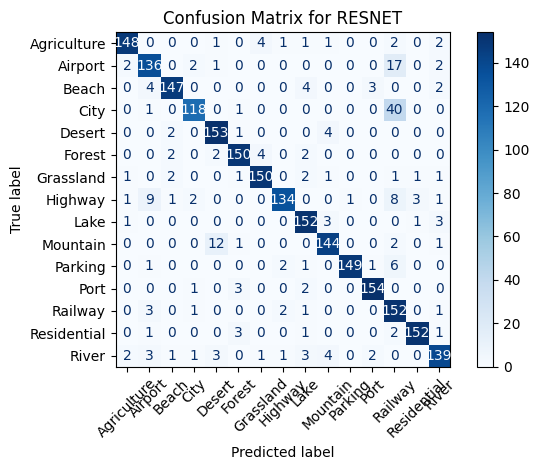

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.0632, Test Acc=0.0667
Epoch 2: Train Acc=0.0669, Test Acc=0.0667
Epoch 3: Train Acc=0.0647, Test Acc=0.0667
Epoch 4: Train Acc=0.0656, Test Acc=0.0667
Epoch 5: Train Acc=0.0638, Test Acc=0.0667
Epoch 6: Train Acc=0.0636, Test Acc=0.0667
⚠️ 早停触发于第 7 轮
===== VGG Evaluation Metrics =====

              precision    recall  f1-score   support

 Agriculture     0.0000    0.0000    0.0000       160
     Airport     0.0000    0.0000    0.0000       160
       Beach     0.0000    0.0000    0.0000       160
        City     0.0000    0.0000    0.0000       160
      Desert     0.0000    0.0000    0.0000       160
      Forest     0.0000    0.0000    0.0000       160
   Grassland     0.0000    0.0000    0.0000       160
     Highway     0.0000    0.0000    0.0000       160
        Lake     0.0000    0.0000    0.0000       160
    Mountain     0.0000    0.0000    0.0000       160
     Parking     0.0000    0.0000    0.0000       160
        Port     0.0000    0.0000    0.0000

/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1200x1000 with 0 Axes>

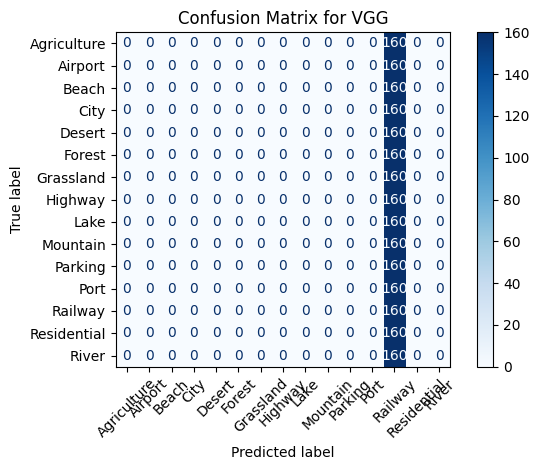

In [11]:
# 同时比较 ResNet 和 VGG
print("🔍 正在比较 ResNet18 与 VGG16 的分类性能...\n")
run_and_evaluate("resnet", classes)
run_and_evaluate("vgg", classes)


In [12]:

import cv2
import numpy as np
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import os
import torch

def overlay_heatmap(img: np.ndarray, cam: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    cam_uint8 = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    if img.max() > 1.0:
        img = np.float32(img) / 255
    if img.shape[:2] != heatmap.shape[:2]:
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    overlayed = heatmap * alpha + img
    overlayed = overlayed / np.max(overlayed)
    return np.uint8(255 * overlayed)

def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def apply_gradcam(model, device, dataloader, model_name="resnet", num_images=5, save_dir="gradcam_outputs", class_names=None):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    if model_name == "resnet":
        target_layer = model.layer4[-1].conv2
    elif model_name == "vgg":
        target_layer = model.features[-1]
    else:
        raise ValueError("Unsupported model")

    cam_extractor = GradCAM(model, target_layer=target_layer)

    shown = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)

        for i in range(min(num_images - shown, inputs.shape[0])):
            img_tensor = inputs[i]
            class_idx = torch.argmax(outputs[i]).item()
            confidence = probs[i][class_idx].item()
            pred_label = class_names[class_idx] if class_names else f"Class {class_idx}"
            true_idx = labels[i].item()
            true_label = class_names[true_idx] if class_names else f"Class {true_idx}"

            cam_tensor = cam_extractor(class_idx=class_idx, scores=outputs[i].unsqueeze(0))[0]
            cam = cam_tensor.cpu().numpy()
            if cam.ndim == 3:
                cam = cam[0]
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

            unnorm_img_tensor = unnormalize(img_tensor.clone().cpu(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            raw_image = unnorm_img_tensor.permute(1, 2, 0).numpy()
            raw_image = np.clip(raw_image, 0, 1)

            cam = cv2.resize(cam, (raw_image.shape[1], raw_image.shape[0]))
            result = overlay_heatmap(raw_image, cam)
            result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

            # Overlay prediction & ground truth
            text = f"Pred: {pred_label} ({confidence*100:.1f}%) | GT: {true_label}"
            cv2.putText(result_rgb, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255,255,255), 2, cv2.LINE_AA)

            # Save
            orig_img = np.uint8(raw_image * 255)
            orig_bgr = cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR)
            orig_path = os.path.join(save_dir, f"original_{model_name}_img{shown}_pred{class_idx}_gt{true_idx}.png")
            cv2.imwrite(orig_path, orig_bgr)

            heatmap_path = os.path.join(save_dir, f"gradcam_{model_name}_img{shown}_pred{class_idx}_gt{true_idx}.png")
            cv2.imwrite(heatmap_path, cv2.cvtColor(result_rgb, cv2.COLOR_RGB2BGR))

            combined = np.hstack((orig_bgr, cv2.cvtColor(result_rgb, cv2.COLOR_RGB2BGR)))
            compare_path = os.path.join(save_dir, f"compare_{model_name}_img{shown}_pred{class_idx}_gt{true_idx}.png")
            cv2.imwrite(compare_path, combined)

            plt.figure(figsize=(5, 5))
            plt.imshow(result_rgb)
            plt.title(text)
            plt.axis('off')
            plt.show()
            cam_extractor.remove_hooks()
            shown += 1
        if shown >= num_images:
            break


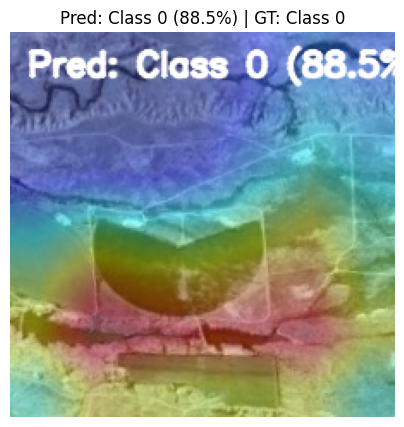

In [15]:
# Example usage
# class_names = ["Forest", "Urban", "Water", ...]
apply_gradcam(model, device, test_loader, model_name="resnet", num_images=1, class_names=None)

In [14]:

import cv2
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM, GradCAMPlusPlus

def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def overlay_heatmap(img: np.ndarray, cam: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    cam_uint8 = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    if img.max() > 1.0:
        img = np.float32(img) / 255
    if img.shape[:2] != heatmap.shape[:2]:
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    overlayed = heatmap * alpha + img
    overlayed = overlayed / np.max(overlayed)
    return np.uint8(255 * overlayed)

def apply_gradcam_compare(model_resnet, model_vgg, device, dataloader, class_names=None, num_images=1, save_dir="gradcam_compare"):
    os.makedirs(save_dir, exist_ok=True)
    model_resnet.eval()
    model_vgg.eval()

    def get_target_layer(model, name):
        if name == "resnet_layer4":
            return model.layer4[-1].conv2
        elif name == "resnet_layer3":
            return model.layer3[-1].conv2
        elif name == "vgg":
            return model.features[-1]
        elif name == "vgg_mid":
            return model.features[16]
        else:
            raise ValueError("Unknown layer name")

    shown = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        outputs_resnet = model_resnet(inputs)
        outputs_vgg = model_vgg(inputs)

        probs_resnet = torch.nn.functional.softmax(outputs_resnet, dim=1)
        probs_vgg = torch.nn.functional.softmax(outputs_vgg, dim=1)

        for i in range(min(inputs.shape[0], num_images)):
            img_tensor = inputs[i]
            true_idx = labels[i].item()

            unnorm_img_tensor = unnormalize(img_tensor.clone().cpu(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            raw_image = unnorm_img_tensor.permute(1, 2, 0).numpy()
            raw_image = np.clip(raw_image, 0, 1)

            def get_cam_output(model, cam_method, layer, output_tensor):
                cam = cam_method(model, target_layer=get_target_layer(model, layer))
                class_idx = torch.argmax(output_tensor[i]).item()
                score = probs_resnet[i][class_idx].item() if model == model_resnet else probs_vgg[i][class_idx].item()
                cam_tensor = cam(class_idx=class_idx, scores=output_tensor[i].unsqueeze(0))[0]
                cam.remove_hooks()
                cam_np = cam_tensor.cpu().numpy()
                if cam_np.ndim == 3:
                    cam_np = cam_np[0]
                cam_np = (cam_np - cam_np.min()) / (cam_np.max() - cam_np.min() + 1e-8)
                cam_np = cv2.resize(cam_np, (raw_image.shape[1], raw_image.shape[0]))
                result = overlay_heatmap(raw_image, cam_np)
                label = class_names[class_idx] if class_names else f"Class {class_idx}"
                true_label = class_names[true_idx] if class_names else f"GT {true_idx}"
                text = f"Pred: {label} ({score*100:.1f}%) | GT: {true_label}"
                cv2.putText(result, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
                return result

            cams = [
                get_cam_output(model_resnet, GradCAM, "resnet_layer4", outputs_resnet),
                get_cam_output(model_resnet, GradCAM, "resnet_layer3", outputs_resnet),
                get_cam_output(model_resnet, GradCAMPlusPlus, "resnet_layer4", outputs_resnet),
                get_cam_output(model_vgg, GradCAM, "vgg", outputs_vgg),
                get_cam_output(model_vgg, GradCAM, "vgg_mid", outputs_vgg),
            ]

            orig_img = np.uint8(raw_image * 255)
            orig_bgr = cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR)

            all_images = [orig_bgr] + [cv2.cvtColor(c, cv2.COLOR_RGB2BGR) for c in cams]
            compare_img = np.hstack(all_images)

            filename = os.path.join(save_dir, f"compare_img{shown}.png")
            cv2.imwrite(filename, compare_img)

            plt.figure(figsize=(16, 4))
            plt.imshow(cv2.cvtColor(compare_img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"Model Comparison - Image {shown}")
            plt.show()

            shown += 1
        if shown >= num_images:
            break


ImportError: cannot import name 'GradCAMPlusPlus' from 'torchcam.methods' (/root/miniconda3/lib/python3.12/site-packages/torchcam/methods/__init__.py)

In [ ]:
# 使用方式
apply_gradcam_compare(model_resnet, model_vgg, device, test_loader, class_names=["Forest", "Urban", "Water"], num_images=1)
